In [1]:
import torch
import sys
import pandas as pd
import multiprocessing
import sys
import seaborn as sns
import importlib
import plotly.express as px
import matplotlib.patches as patches

sys.path.append('../')
from run_patching_experiment import run_patching 

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device =', device)
torch.set_grad_enabled(False)

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")

else:
    print("CUDA is not available. Listing CPUs instead.")
    print(multiprocessing.cpu_count())

/home/jsalle/.conda/envs/p11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = cpu
CUDA is not available. Listing CPUs instead.
48


## Run

In [2]:
prompt_dict = run_patching(prompt_dict_filename="../data/var_loopid.py",
             model_name="gemma-2b",
             layers=[5, 11, 12, 13, 14, 15, 16],
             output_folder='../outputs',
             output_file_name='var_loopid_gemma-2b.pkl'
)

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.
Baseline completion:   0%|          | 0/4 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_O

KeyboardInterrupt: 

In [21]:
dict = pd.read_pickle('../outputs/big_five_gemma-7b.pkl')
print(f'Number of patchings: {len(dict)}')

Number of patchings: 2


## Plot

In [6]:
def format_df_for_plots(model_name, 
                         patch_dict_path: str,
                         value = 'acc', # 'proba', 'logits'
                         layers = [5, 11, 12, 13, 14, 15, 16],
                         constant = ''):

    assert constant in ['', 'R', 'C', 'no_filter']

    n_filtered = 0
    patch_dict = pd.read_pickle(patch_dict_path)

    val_df = pd.DataFrame(columns=['pair', 'request_context', 'layer', 'acc', 'proba', 'logit'])
    for i, pair in enumerate(patch_dict):

        R2_C2 = patch_dict[f'pair_{i}']['R2_C2']
        R1_C1 = patch_dict[f'pair_{i}']['R1_C1']
        R1_C2 = patch_dict[f'pair_{i}']['R1_C2']
        R2_C1 = patch_dict[f'pair_{i}']['R2_C1']

        if constant == '':
            if not (R1_C1 != R2_C2 and
                    R1_C1 != R1_C2 and 
                    R1_C1 != R2_C1 and 
                    R2_C2 != R1_C2 and 
                    R2_C2 != R2_C1 and 
                    R1_C2 != R2_C1):
                n_filtered += 1
                continue
        elif constant == 'R':
            if not (R1_C2 == R2_C2 and
                    R1_C1 == R2_C1):
                n_filtered += 1
                continue
        elif constant == 'C':
            if not (R1_C1 == R1_C2 and
                    R2_C1 == R2_C2):
                n_filtered += 1
                continue
 

        for layer_id in layers:
            for request_context, name in zip([R2_C2, R1_C1, R1_C2, R2_C1], 
                                             ['R2C2', 'R1C1', 'R1C2', 'R2C1']):
                acc = 1 if request_context == patch_dict[f'pair_{i}'][f'token_l{layer_id}'] else 0
                proba = patch_dict[f'pair_{i}'][f'{name}_proba_l{layer_id}']
                logit = patch_dict[f'pair_{i}'][f'{name}_logit_l{layer_id}']
                
                temp_series = pd.DataFrame([{'pair': i, 
                                             'request_context': name, 
                                             'layer': layer_id, 
                                             'acc': acc,
                                             'proba': proba,
                                             'logit': logit}])
                val_df = pd.concat([val_df, temp_series], ignore_index=True)
        
    print(f'Filtered pairs: {n_filtered}/{len(patch_dict)}, Remaining: {int(len(val_df)/(4*len(layers)))}')

    return val_df


def plot_acc_or_proba(val_df,
                      value = 'acc', # 'proba', 'logit'
                      title: str = '',
                      model_name: str = 'gemma-2b'):

    agg_df = val_df.groupby(['request_context', 'layer'], as_index=False)[value].mean()
    fig = px.line(agg_df, x='layer', y=f'{value}',
                  color='request_context',
                  title=f'{title} ({model_name})',
                  width=800,
                  height=500,
                  markers=True)
    
    return fig


def plot_baseline_accuracy(patch_dict_path: str,
                           results_dict: dict):
    
    # TODO: il faudra reprendre ici la groundtruth !!

    cleaning_df = pd.DataFrame()
    groundtruth_dict = {}

    # if the prompt dict is in a python file
    module_name = patch_dict_path[:-3]  # Remove .py extension
    spec = importlib.util.spec_from_file_location(module_name, patch_dict_path)
    prompt_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(prompt_module)
    patch_dict = prompt_module.prompt_dict

    for pair in patch_dict:
        R = patch_dict[pair]['R']
        C = patch_dict[pair]['C']
        if f'{R}_{C}' not in groundtruth_dict:
            groundtruth_dict[f'{R}_{C}'] = patch_dict[pair]['groundtruth']

    for pair in results_dict:
        R1 = results_dict[pair]['R1']
        C1 = results_dict[pair]['C1']
        R2 = results_dict[pair]['R2']
        C2 = results_dict[pair]['C2']

        # TODO: correct the 'in'
        acc = 1 if results_dict[pair]['R1_C1'] == groundtruth_dict[f'{R1}_{C1}'] else 0
        temp_dict = {'R': R1,
                    'C': C1,
                    'acc': acc,
                    'groundtruth': groundtruth_dict[f'{R1}_{C1}'],
                    'answer': results_dict[pair]['R1_C1']}
        
        df_dictionary = pd.DataFrame([temp_dict])
        cleaning_df = pd.concat([cleaning_df, df_dictionary], ignore_index=True)

    cleaning_df.drop_duplicates(inplace=True)

    palette = sns.color_palette("vlag_r", as_cmap=True)
    result = cleaning_df.pivot(index='R', columns='C', values='acc')
    gd = cleaning_df.pivot(index='R', columns='C', values='groundtruth')
    answers = cleaning_df.pivot(index='R', columns='C', values='answer')
    sns.heatmap(result, annot=gd, annot_kws={'va':'bottom'}, fmt='', cmap=palette, linecolor='white', linewidth=1, square=True, cbar=False, vmin=0, vmax=1)
    sns.heatmap(result, annot=answers, annot_kws={'va':'top', 'color':'grey'}, fmt="", cmap=palette, linecolor='white', linewidth=1, square=True, cbar=False, vmin=0, vmax=1)
    return

## Vizualisations

Number of patchings: 568


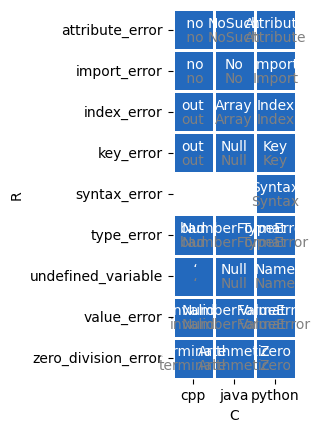

In [4]:
dict = pd.read_pickle('../outputs/programming_problems_bis_gemma-2b.pkl')
print(f'Number of patchings: {len(dict)}')

plot_baseline_accuracy(patch_dict_path='../data/programming_problems_bis.py',
                       results_dict=dict)

In [96]:
val_df = format_df_for_plots(model_name='gemma-2b',
                             patch_dict_path='../outputs/programming_problems_bis_gemma-2b.pkl',
                             layers = [9, 10, 11, 12, 13, 14, 15, 16],
                             constant='C')

plot_acc_or_proba(val_df=val_df,
                  value='logit')

Filtered pairs: 384/568, Remaining: 184


In [42]:
dict = pd.read_pickle('../outputs/programming_problems_bis_gemma-2b.pkl')
print(f'Number of patchings: {len(dict)}')

dict['pair_0']

Number of patchings: 568


{'context_1': 'Here is a Python program I wrote. It is not working. Can you help me fix it?\n\nif True\n    print("Hello")\n\nI ran this code and it raised the following error <code>',
 'context_2': 'Here is a Python program I wrote. It is not working. Can you help me fix it?\n\nz = 3\nprint(x)\n\nI ran this code and it raised the following error <code>',
 'R1': 'syntax_error',
 'R2': 'undefined_variable',
 'C1': 'python',
 'C2': 'python',
 'R1_C1': 'Syntax',
 'R2_C2': 'Name',
 'R1_C2': 'Syntax',
 'R2_C1': 'Name',
 'token_l9': 'Name',
 'R1C1_proba_l9': 0.05840324,
 'R2C1_proba_l9': 0.3591559,
 'R1C2_proba_l9': 0.05840324,
 'R2C2_proba_l9': 0.3591559,
 'R1C1_logit_l9': 4.735481262207031,
 'R2C1_logit_l9': 6.55186653137207,
 'R1C2_logit_l9': 4.735481262207031,
 'R2C2_logit_l9': 6.55186653137207,
 'token_l10': 'Name',
 'R1C1_proba_l10': 0.064808235,
 'R2C1_proba_l10': 0.33577418,
 'R1C2_proba_l10': 0.064808235,
 'R2C2_proba_l10': 0.33577418,
 'R1C1_logit_l10': 4.947944641113281,
 'R2C1_lo

In [47]:
df = pd.DataFrame.from_dict(dict, orient='index',
                            columns=['R1', 'C1', 'R2', 'C2']+
                                    [k for k in dict['pair_0'].keys() if 'token' in k]+
                                    ['R1_C1', 'R1_C2', 'R2_C1', 'R2_C2'])
df

,R1,C1,R2,C2,token_l9,token_l10,token_l11,token_l12,token_l13,token_l14,token_l15,token_l16,R1_C1,R1_C2,R2_C1,R2_C2
pair_0,syntax_error,python,undefined_variable,python,Name,Name,Name,Syntax,Syntax,Syntax,Syntax,Syntax,Syntax,Syntax,Name,Name
pair_1,syntax_error,python,type_error,python,TypeError,TypeError,TypeError,Syntax,Syntax,Syntax,Syntax,Syntax,Syntax,Syntax,TypeError,TypeError
pair_2,syntax_error,python,value_error,python,ValueError,ValueError,ValueError,Syntax,Syntax,Syntax,Syntax,Syntax,Syntax,Syntax,ValueError,ValueError
pair_3,syntax_error,python,index_error,python,Index,Index,Index,Syntax,Syntax,Syntax,Syntax,Syntax,Syntax,Syntax,Index,Index
pair_4,syntax_error,python,key_error,python,Key,Key,Key,Syntax,Syntax,Syntax,Syntax,Syntax,Syntax,Syntax,Key,Key
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pair_563,undefined_variable,cpp,attribute_error,cpp,no,no,no,',',',',',‘,‘,no,no
pair_564,undefined_variable,cpp,key_error,cpp,no,no,no,use,',',',',‘,‘,out,out
pair_565,undefined_variable,cpp,index_error,cpp,use,no,use,use,use,',',',‘,‘,out,out
pair_566,undefined_variable,cpp,value_error,cpp,invalid,invalid,invalid,use,',',',',‘,‘,invalid,invalid


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt



def plot_mixed_heatmap(initial_df, 
                       indexes, 
                       filter,
                       fontsize=5):

    assert filter in ['R', 'C', '', 'remove_java']

    def color_row(row):
        value_dict = {row['R1_C1']: 0, 
                    row['R1_C2']: 1 if row['R1_C1'] != row['R1_C2'] else 0, 
                    row['R2_C1']: 2 if row['R2_C1'] != row['R2_C2'] else 3, 
                    row['R2_C2']: 3}
        
        row = row.replace(value_dict)
        return row

    initial_df = initial_df[indexes[0]:indexes[1]]

    if filter == 'R':
        initial_df = initial_df[initial_df['R1_C1'] == initial_df['R2_C1']]
        initial_df = initial_df[initial_df['R1_C2'] == initial_df['R2_C2']]
    if filter == 'C':
        initial_df = initial_df[initial_df['R1_C1'] == initial_df['R1_C2']]
        initial_df = initial_df[initial_df['R2_C1'] == initial_df['R2_C2']]
    if filter == 'remove_java':
        initial_df = initial_df[initial_df['C1'] != 'java']
        initial_df = initial_df[initial_df['C2'] != 'java']
    
    df = initial_df.apply(lambda row: color_row(row), axis=1)

    fig, ax = plt.subplots(figsize=(11,8))
    mask = df.applymap(lambda x: isinstance(x, (int, float)))

    # Create a heatmap for the numeric data
    sns.heatmap(
        df.where(mask, other=0).astype(float), 
        mask=~mask, 
        annot=False, 
        fmt="", 
        cmap="YlGnBu", 
        cbar_kws={'label': 'Numeric Values'},
        linewidths=.5,
        linecolor='gray',
        cbar=False
    )

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            if not mask.iloc[i, j]:
                plt.text(j + 0.5, i + 0.5, df.iloc[i, j], ha='center', 
                         va='center', color='black',
                         fontsize=fontsize)
            if df.iloc[i, j] in [3]:
                plt.text(j + 0.5, i + 0.5, initial_df.iloc[i, j], ha='center', 
                         va='center', color='white',
                         fontsize=fontsize)
            if df.iloc[i, j] in [0, 1, 2]:
                plt.text(j + 0.5, i + 0.5, initial_df.iloc[i, j], ha='center', 
                         va='center', color='black',
                         fontsize=fontsize)

                
    rect = patches.Rectangle((df.shape[1] - 4, 0), 4, df.shape[0], linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return

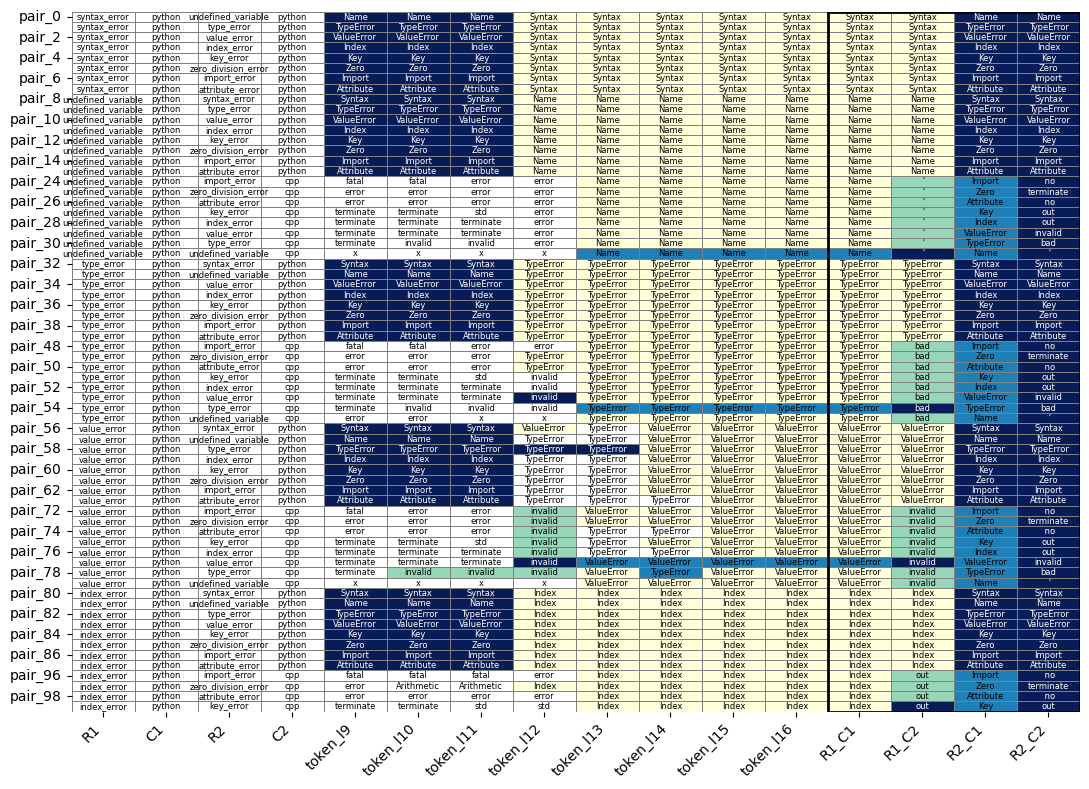

In [183]:
plot_mixed_heatmap(df, indexes=(0, 100), filter='remove_java', fontsize=6)

# Personality test

In [4]:
dict = pd.read_pickle('../outputs/programming_problems_bis_gemma-7b.pkl')
print(f'Number of patchings: {len(dict)}')

Number of patchings: 339


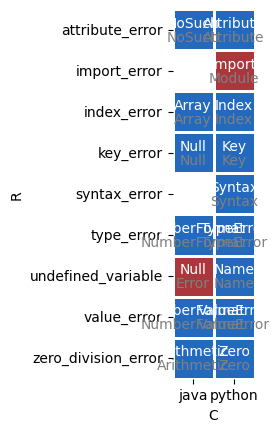

In [7]:
plot_baseline_accuracy(patch_dict_path='../data/programming_problems_bis.py',
                       results_dict=dict)

In [11]:
val_df = format_df_for_plots(model_name='gemma-7b',
                             patch_dict_path='../outputs/programming_problems_bis_gemma-7b.pkl',
                             layers = [9, 10, 11, 12, 13, 14, 15, 16],
                             constant='C')

plot_acc_or_proba(val_df=val_df,
                  value='acc')

Filtered pairs: 225/339, Remaining: 114
